In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [4]:
ls

 Volume in drive C has no label.
 Volume Serial Number is E605-7EFA

 Directory of c:\Users\Joel Larsen\OneDrive\Documents\Projects\AI_Capstone

17/03/2024  04:02 PM    <DIR>          .
17/03/2024  04:02 PM    <DIR>          ..
17/03/2024  04:47 PM               802 Capstone_EDA.ipynb
17/03/2024  04:02 PM    <DIR>          daily_chart
05/03/2024  06:12 PM       431,839,089 daily_report.csv
17/03/2024  03:56 PM       223,416,700 dataset_updated (1).zip
05/03/2024  05:34 PM         1,304,135 login.csv
06/03/2024  12:36 AM             2,691 README.md
04/03/2024  05:30 PM                91 reason.csv
05/03/2024  10:30 PM             4,640 symbol.csv
05/03/2024  10:26 PM       472,526,480 trades.csv
               8 File(s)  1,129,094,628 bytes
               3 Dir(s)  66,952,155,136 bytes free


In [57]:
daily_report_df = pd.read_csv('daily_report.csv')
trades_df = pd.read_csv('trades.csv')

In [8]:
daily_report_df

,login,record_time,net_deposit,balance,equity,credit,profit_closed,profit_floating,margin
0,457547,2023-01-01,0.0,0.00,0.00,0.0,0.00,0.00,0.00
1,474589,2023-01-01,0.0,0.56,0.56,0.0,0.00,0.00,0.00
2,504321,2023-01-01,0.0,2.03,2.03,0.0,0.00,0.00,0.00
3,504322,2023-01-01,0.0,0.51,0.51,0.0,0.00,0.00,0.00
4,504326,2023-01-01,0.0,0.01,0.01,0.0,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...
8664156,1000055123,2024-02-29,0.0,37521.00,36507.56,0.0,-122.18,-1013.44,818.92
8664157,1000055441,2024-02-29,0.0,0.00,0.00,0.0,0.00,0.00,0.00
8664158,1000055515,2024-02-29,0.0,0.00,0.00,0.0,0.00,0.00,0.00
8664159,1000059485,2024-02-29,0.0,0.00,0.00,0.0,0.00,0.00,0.00


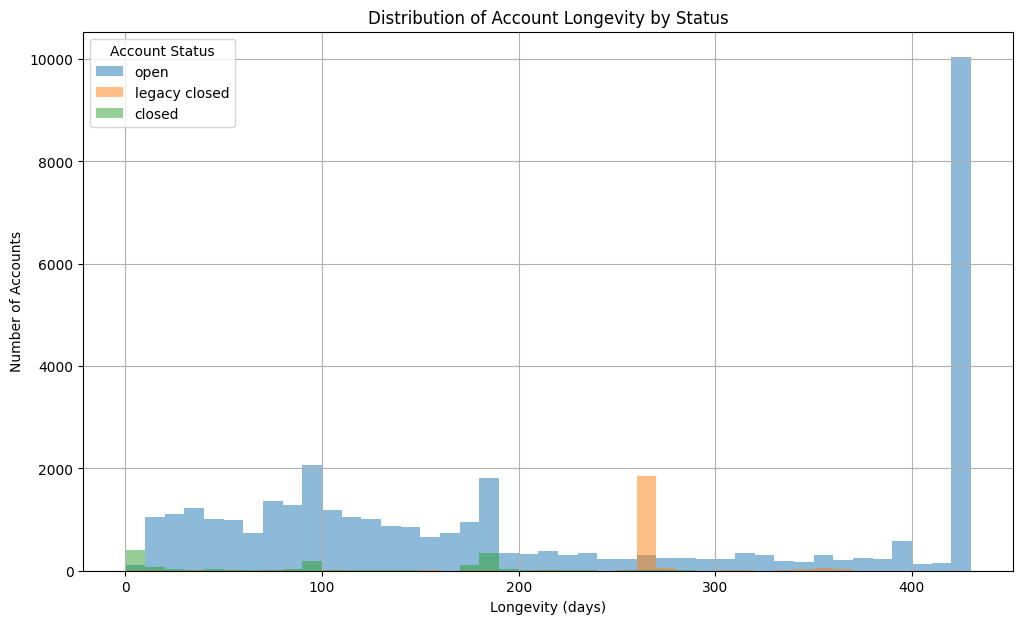

In [27]:
# Calculate the first and last trade dates for each account
account_lifespans = daily_report_df.groupby('login').agg(
    first_trade=('record_time', 'min'),
    last_trade=('record_time', 'max')
).reset_index()

# Calculate account longevity in days
account_lifespans['longevity'] = (account_lifespans['last_trade'] - account_lifespans['first_trade']).dt.days
two_months_ago = daily_report_df['record_time'].max() - pd.DateOffset(months=2)
first_month_start = daily_report_df['record_time'].min()
two_months_from_start = first_month_start + pd.DateOffset(months=2)

# Assign 'legacy closed' to accounts that started in the first month and did not trade in the last two months
account_lifespans['status'] = np.where(
    (account_lifespans['first_trade'] <= two_months_from_start) & 
    (account_lifespans['last_trade'] <= two_months_ago),
    'legacy closed', 'open'
)

# Assign 'closed' status to the rest of the accounts whose last trade is before two months ago
account_lifespans['status'] = np.where(
    (account_lifespans['last_trade'] <= two_months_ago) & 
    (account_lifespans['status'] != 'legacy closed'),
    'closed', account_lifespans['status']
)

# Create bins for longevity
max_longevity = account_lifespans['longevity'].max()
bins = range(0, max_longevity + 10, 10)  # Adjust bin width as needed

# Plotting the histogram
plt.figure(figsize=(12, 7))
for status in ['open', 'legacy closed', 'closed']:
    subset = account_lifespans[account_lifespans['status'] == status]
    plt.hist(subset['longevity'], bins=bins, alpha=0.5, label=status)

plt.title('Distribution of Account Longevity by Status')
plt.xlabel('Longevity (days)')
plt.ylabel('Number of Accounts')
plt.legend(title='Account Status')
plt.grid(True)
plt.show()

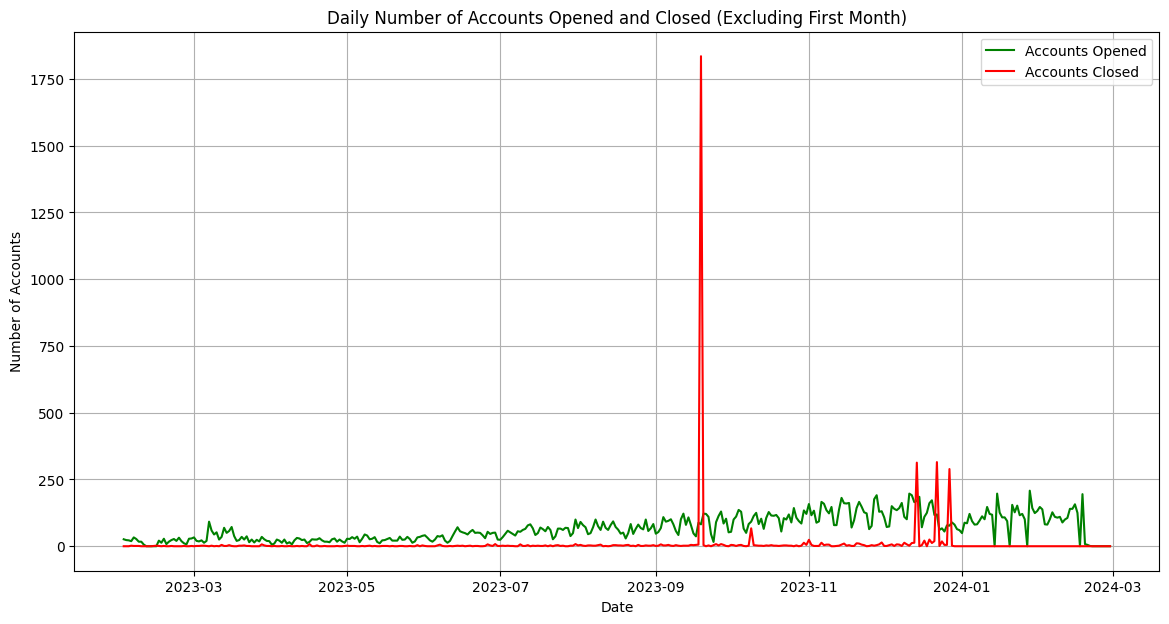

In [33]:
# Adjust the date range to exclude only the first month
start_date = daily_report_df['record_time'].min() + pd.DateOffset(months=1)
end_date = daily_report_df['record_time'].max()
adjusted_date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Initialize a DataFrame to store the daily counts of opened and closed accounts within the adjusted date range
adjusted_daily_counts = pd.DataFrame(index=adjusted_date_range)
adjusted_daily_counts['opened'] = 0
adjusted_daily_counts['closed'] = 0

# Count the number of accounts opened each day within the adjusted range
adjusted_openings = account_lifespans[(account_lifespans['first_trade'] >= start_date) & (account_lifespans['first_trade'] <= end_date)].groupby('first_trade').size()
adjusted_daily_counts['opened'] = adjusted_daily_counts.index.map(adjusted_openings).fillna(0)

# To ensure we don't consider accounts with trades in the last two months as closed
two_months_ago = end_date - pd.DateOffset(months=2)
adjusted_closings = account_lifespans[(account_lifespans['last_trade'] >= start_date) & 
                                      (account_lifespans['last_trade'] <= end_date) & 
                                      (account_lifespans['last_trade'] <= two_months_ago)].groupby('last_trade').size()
adjusted_daily_counts['closed'] = adjusted_daily_counts.index.map(adjusted_closings).fillna(0)

# Plotting the line chart for daily opened and closed accounts within the adjusted date range
plt.figure(figsize=(14, 7))
plt.plot(adjusted_daily_counts.index, adjusted_daily_counts['opened'], label='Accounts Opened', color='green')
plt.plot(adjusted_daily_counts.index, adjusted_daily_counts['closed'], label='Accounts Closed', color='red')

plt.title('Daily Number of Accounts Opened and Closed (Excluding First Month)')
plt.xlabel('Date')
plt.ylabel('Number of Accounts')
plt.legend()
plt.grid(True)
plt.show()

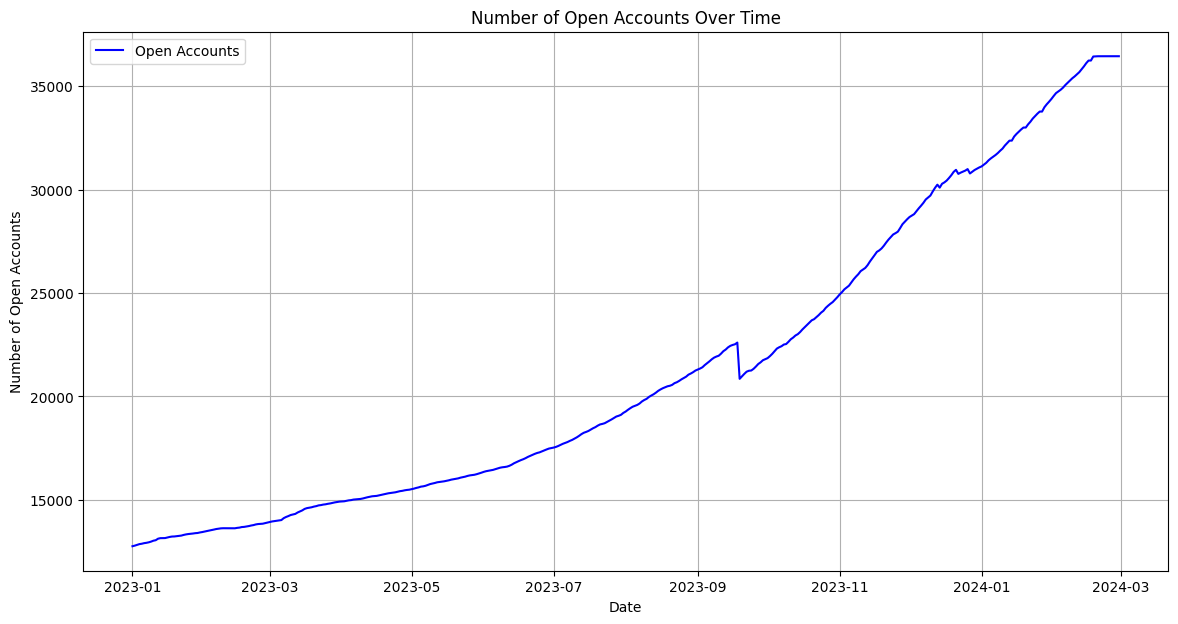

In [35]:
# Initialize a DataFrame to store the daily counts of opened and closed accounts for the entire dataset
daily_counts = pd.DataFrame(index=date_range)
daily_counts['opened'] = 0
daily_counts['closed'] = 0

# Count the number of accounts opened each day for the entire dataset
openings = account_lifespans.groupby('first_trade').size()
daily_counts['opened'] = daily_counts.index.map(openings).fillna(0)

# Count the number of accounts closed each day for the entire dataset, considering the last two months' logic
two_months_ago = daily_report_df['record_time'].max() - pd.DateOffset(months=2)
closings = account_lifespans[(account_lifespans['last_trade'] <= two_months_ago)].groupby('last_trade').size()
daily_counts['closed'] = daily_counts.index.map(closings).fillna(0)

# Calculate the cumulative sum of opened and closed accounts
daily_counts['cumulative_opened'] = daily_counts['opened'].cumsum()
daily_counts['cumulative_closed'] = daily_counts['closed'].cumsum()

# Calculate the number of open accounts over time
daily_counts['open_accounts'] = daily_counts['cumulative_opened'] - daily_counts['cumulative_closed']

# Plotting the line chart for the number of open accounts over time
plt.figure(figsize=(14, 7))
plt.plot(daily_counts.index, daily_counts['open_accounts'], label='Open Accounts', color='blue')

plt.title('Number of Open Accounts Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Open Accounts')
plt.legend()
plt.grid(True)
plt.show()

In [59]:
trades_df

,ticket,login,symbol,cmd,volume,open_time,open_price,close_time,close_price,tp,sl,reason,commission,swaps,profit,volume_usd
0,68880703,7062462,XAUUSD,0,0.01,1707843941,1991.35000,1708013114,2003.01000,0.00000,0.00000,1,0.00,-1.12,10.83,3994.36
1,68880910,7062462,XAUUSD,0,0.02,1707844129,1990.30000,1708013110,2002.76000,0.00000,0.00000,1,0.00,-2.25,23.16,7986.12
2,68120690,813125,US2000,0,1.00,1706083005,1983.22000,1706114503,1996.68000,2012.34000,1980.03000,1,0.00,0.00,105.42,39799.00
3,68169249,813125,US2000,0,2.00,1706139371,1960.62000,1706200143,1991.51000,2331.85000,1958.94000,1,0.00,-7.21,485.26,79042.60
4,68186877,88945036,NZDUSD,0,0.13,1706169600,0.61062,1706197106,0.61317,0.61312,0.55059,1,-0.91,0.00,33.15,15909.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4521772,68795989,810950,XAUUSD,0,0.10,1707738783,2020.74000,1707810805,2021.51000,2026.00000,0.00000,5,0.00,0.00,7.70,40422.50
4521773,68796026,810950,XAUUSD,0,0.10,1707738794,2020.70000,1707810809,2021.50000,2026.00000,0.00000,5,0.00,0.00,8.00,40422.00
4521774,68854039,810799,EURUSD,1,0.10,1707825414,1.07654,1707825616,1.07693,0.00000,1.07694,5,-0.60,0.00,-3.62,21534.70
4521775,68785760,810710,GER30,1,0.03,1707728945,16994.30000,1707824463,16934.00000,0.00000,17120.00000,5,0.00,0.13,18.09,10931.50


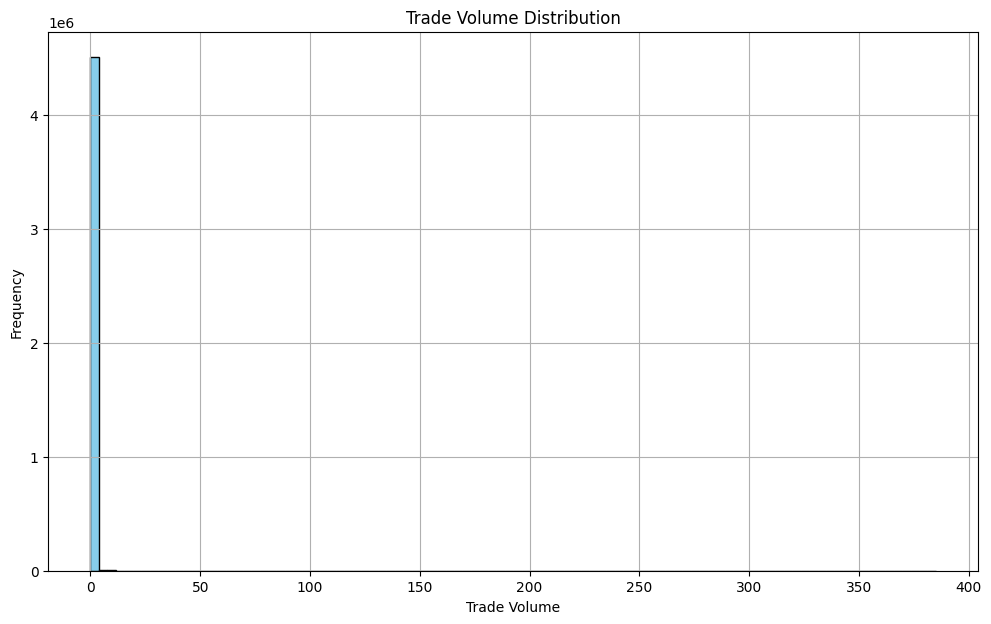

In [51]:
plt.figure(figsize=(12, 7))
plt.hist(trades_df['volume'], bins=100, color='skyblue', edgecolor='black')
plt.title('Trade Volume Distribution')
plt.xlabel('Trade Volume')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

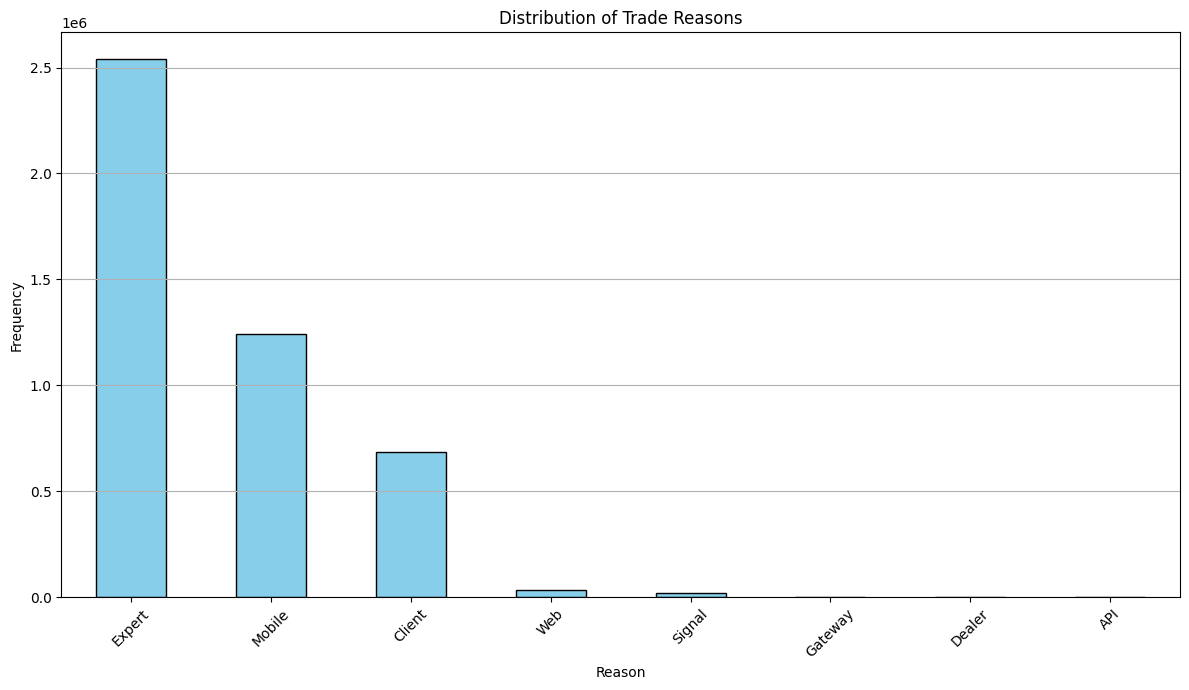

In [60]:
import matplotlib.pyplot as plt

# Create a mapping dictionary from the provided reason codes to reason descriptions
reason_mapping = {0: 'Client', 1: 'Expert', 2: 'Dealer', 3: 'Signal', 4: 'Gateway', 5: 'Mobile', 6: 'Web', 7: 'API'}

# Count the occurrences of each reason in trades_df
reason_counts = trades_df['reason'].map(reason_mapping).value_counts()

plt.figure(figsize=(12, 7))
reason_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Trade Reasons')
plt.xlabel('Reason')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

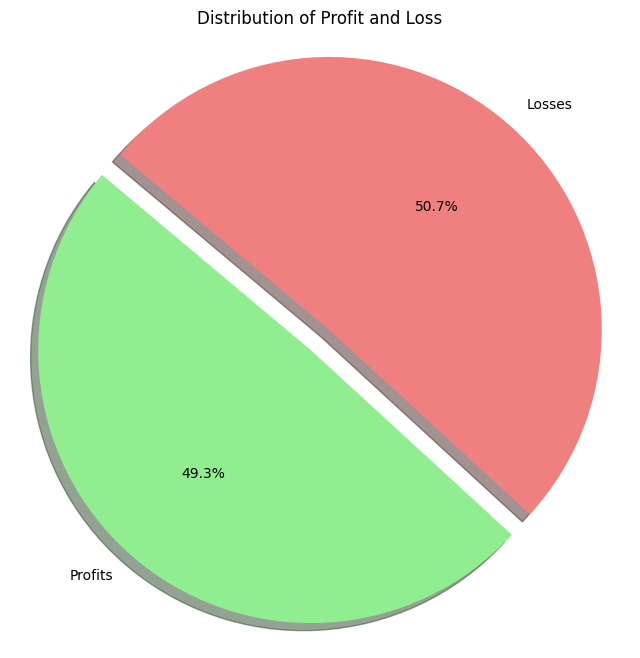

In [62]:
# Calculate the sum of positive profits (profits) and negative profits (losses)
positive_profits = trades_df['profit'][trades_df['profit'] > 0].sum()
negative_losses = trades_df['profit'][trades_df['profit'] < 0].sum()

# Prepare data for the pie chart
labels = ['Profits', 'Losses']
sizes = [positive_profits, abs(negative_losses)]  # Take the absolute value of negative losses for visualization
colors = ['lightgreen', 'lightcoral']
explode = (0.1, 0)  # Explode the 'Positive Profits' slice

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribution of Profit and Loss')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

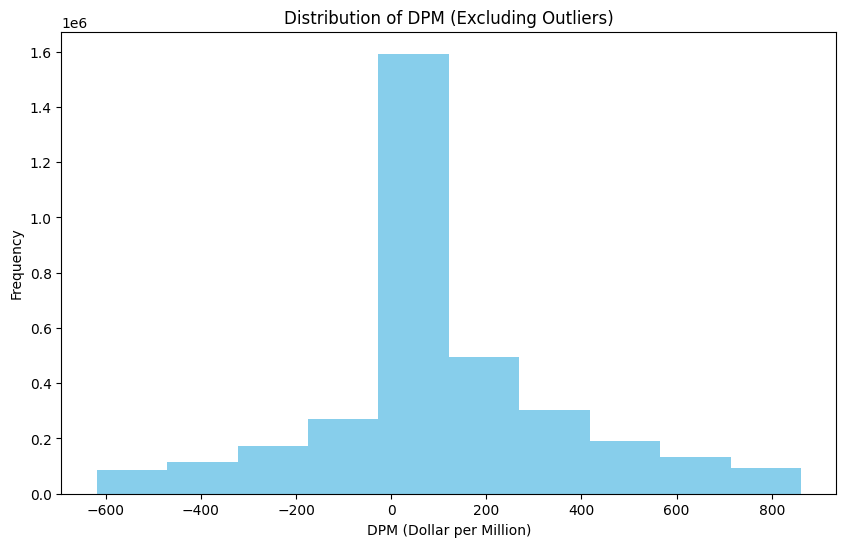

In [86]:
## Calculate DPM for each trade
trades_df['dpm'] = trades_df['profit'] / (trades_df['volume_usd'] / 1_000_000)

# Determine the interquartile range (IQR)
Q1 = trades_df['dpm'].quantile(0.25)
Q3 = trades_df['dpm'].quantile(0.75)
IQR = Q3 - Q1

# Define the upper and lower bounds for the outlier
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
filtered_trades_df = trades_df[(trades_df['dpm'] >= lower_bound) & (trades_df['dpm'] <= upper_bound)]

# Plotting the distribution of DPM without outliers
plt.figure(figsize=(10, 6))
plt.hist(filtered_trades_df['dpm'], bins=10, color='skyblue')
plt.title('Distribution of DPM (Excluding Outliers)')
plt.xlabel('DPM (Dollar per Million)')
plt.ylabel('Frequency')
plt.show()